## *Purpose*

The purpose of this jupyter notebook is to retrieve **historical data** from **Twitter** using the **GET /2/tweets/search/all endpoint**. Important notes about the code and some helpful links can be found at the end of this notebook. By using this notebook one can understand the data retrieval process step by step. Otherwise, the .py script does the job, and just needs to be run in the command line or setting up a cronjob (if applicable).

Note that in order to use this specific endpoint you need to have **Academic Research Access**: https://developer.twitter.com/en/products/twitter-api/academic-research

## package imports
All the necessary packages to retrieve data from twitter API GET /2/tweets/search/all endpoint.

In [1]:
import requests
import json
import time
import random

## Credentials

Twitter API credentials. You just need to replace the XXX by your bearer token.

In [2]:
bearer_token = "XXX"

## Full archive search endpoint URL

In [4]:
search_url = "https://api.twitter.com/2/tweets/search/all"

## Rules/queries for data extraction
This json file contains the rule(s) for the data extraction.

### Example file of how to write rules:
This would be an example of retrieving geolocated tweets outside the US about knife crime.

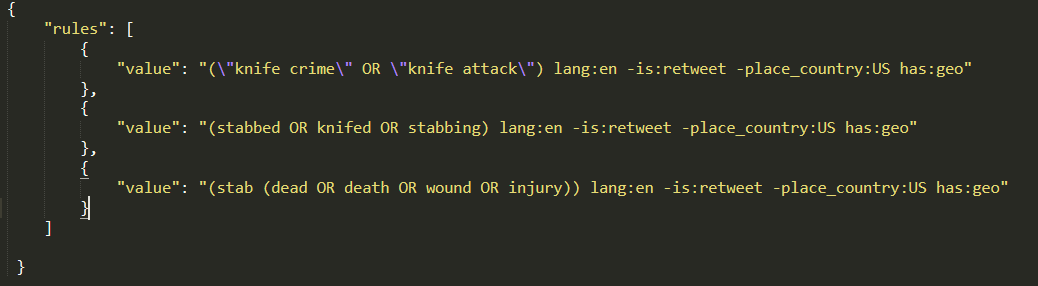

#### First rule explained:

Retrieving tweets that comply with the following 2 constraints:
- Contain at least one of the expressions: "knife crime",  "knife attack"
- Are in english, are not retweets, geolocated outside of the US

#### Third rule explained:

Retrieving tweets that comply with the following 3 constraints:
- Contain keyword stab (if stabbed appears instead of stab, the tweet is not retrieved - as it is a tokenized match)
- Contains at least one of the following keywords: dead, death, wound or injury
- Are in english, are not retweets, geolocated outside of the US

In [5]:
with open('rules.json', 'r') as f:
    queries = json.load(f)

## Functions

Function to create headers using the bearer token:

In [6]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

Sometimes when connecting to the endpoint there are errors. If the response code is 200, all is good. If the response yields a different status code then there was an error. I am printing these errors, but you can comment the print statements if you are not interested in knowing which type of error was yielded. When there is an error I make my program sleep between 5 and 60 seconds before trying again.

More about response codes [here].

[here]: https://developer.twitter.com/ja/docs/basics/response-codes

In [7]:
def connect_to_endpoint(url, headers, params):
    response = requests.request("GET", url, headers=headers, params=params)
    if response.status_code != 200:
        print(response.status_code)
        rn = random.randint(5,60)
        print('Sleeping '+str(rn)+' seconds...')
        time.sleep(rn)
        return connect_to_endpoint(url, headers, params)
    return response.json()

There are a million ways of storing the data one retrieves from the API. I have decided to store json dictionaries *data*, *users*, *tweets*, *places*, *errors* separately. I store the data retrieved from the endpoint separately by query and with a maximum of 25 pages with 100 instances each, so there is a file number associated with each json saved:

In [8]:
def transform_JSON_response(json, data, users, tweets, places, errors):
    data = data + json['data']
    users = users + json['includes']['users']
    
    if 'tweets' in json['includes'].keys():
        tweets = tweets + json['includes']['tweets']
    
    if 'places' in json['includes'].keys():
        places = places + json['includes']['places']
    
    if 'errors' in json.keys():
        errors = errors + json['errors']
        
    return data, users, tweets, places, errors

In [9]:
def save_data(data, users, tweets, places, errors, query, file):
    with open('./data/data_query'+str(query)+'_file'+str(file)+'.json','w', encoding='utf8') as tf:
        json.dump(data, tf, indent = 4, ensure_ascii = False)

    with open('./data/users_query'+str(query)+'_file'+str(file)+'.json','w', encoding='utf8') as tf:
        json.dump(users, tf, indent = 4, ensure_ascii = False)
    
    with open('./data/tweets_query'+str(query)+'_file'+str(file)+'.json','w', encoding='utf8') as tf:
        json.dump(tweets, tf, indent = 4, ensure_ascii = False)

    with open('./data/places_query'+str(query)+'_file'+str(file)+'.json','w', encoding='utf8') as tf:
        json.dump(places, tf, indent = 4, ensure_ascii = False)

    with open('./data/errors_query'+str(query)+'_file'+str(file)+'.json','w', encoding='utf8') as tf:
        json.dump(errors, tf, indent = 4, ensure_ascii = False)

Function to reset lists to empty:

In [10]:
def reset_lists():
    return [], [], [], [], []

## Retrieving data from API

Headers:

In [11]:
headers = create_headers(bearer_token)

Dates and times to cover (in UTC time):

*One just needs to set this according to the time range needed.*


In [12]:
datetime_start = "2020-01-01T00:00:00Z"
datetime_end = "2020-01-02T23:59:59Z"

Retrieving and saving tweets:

In [13]:
for i in range(len(queries['rules'])):
    #reset lists to empty
    list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors = reset_lists()

    #set page and file to 1
    page = 1
    file = 1

    #define query parameters depending on query and start and end datetimes
    query_params = {'query': queries['rules'][i]['value'],
        'tweet.fields': 'id,text,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields':'id,name,username,created_at,description,entities,location,public_metrics,url,verified',
        'place.fields':'full_name,id,contained_within,country,country_code,geo,name,place_type',
        'expansions':'author_id,entities.mentions.username,geo.place_id,in_reply_to_user_id,referenced_tweets.id,referenced_tweets.id.author_id',
        'start_time':datetime_start,
        'end_time':datetime_end,
        'max_results':100
       }

    #getting first page of tweets
    json_response = connect_to_endpoint(search_url, headers, query_params)

    #sleep for 3.2 seconds not to surpass the rate limit
    time.sleep(3.2)

    if 'data' in json_response:
        #updating lists with new data
        list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors = transform_JSON_response(json_response, list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors)


    #if there are more tweets then the meta field will have a next token key-pair
    while 'next_token' in json_response['meta']:
        #updating the query parameters to specify the page, using the next token
        query_params['next_token'] = json_response['meta']['next_token']

        #getting next page of tweets
        json_response = connect_to_endpoint(search_url, headers, query_params)

        #sleep for 3.2 seconds not to surpass the rate limit
        time.sleep(3.2)


        if 'data' in json_response:
            #updating lists with new data
            list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors = transform_JSON_response(json_response, list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors)

        #update page number
        page = page + 1


        #if we get to the 25th page, we store data and reset the lists to empty
        #so that each one of the json files is not very big
        if page % 25 == 0:
            print(str(page)+' pages')
            save_data(list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors, i, file)
            list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors = reset_lists()
            file = file + 1
    if len(list_data)>0 or len(list_includes_tweets)>0:
        save_data(list_data, list_includes_users, list_includes_tweets, list_includes_places, list_errors, i, file)
    print("Finished query "+str(i))

Finished query 0
Finished query 1
Finished query 2


## Important notes about the above code and useful links:
- **Query parameters:** version 2 of Twitter API allows you to choose which fields/variables you want to retrieve, so you can change this by changing the query parameters dictionary, *query_params*. More info can be found in https://developer.twitter.com/en/docs/twitter-api/fields
- **Number of requests**: Each endpoint has its own limits like maximum number of tweets retrieved per month and number of requests in a certain amount of time per app and per user. The GET /2/tweets/search/all endpoint allows you to do 300 requests per 15 minute time window which corresponds to 1 request every 3 seconds so I made my program sleep 3.2 seconds in between requests. You can have access to this information per endpoint signing in to your developer portal: https://developer.twitter.com/en/portal/products

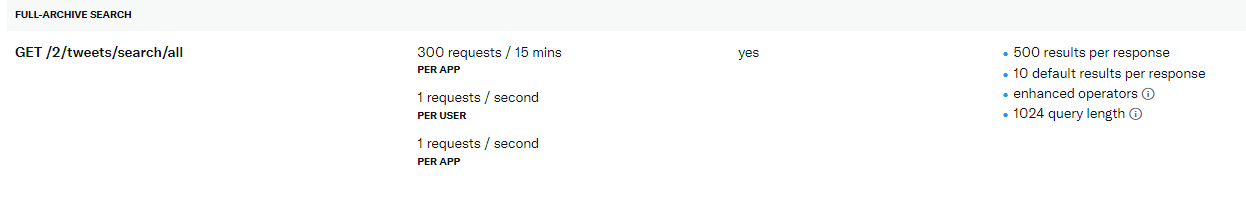

- **Max number of pages in one json file**: you can save your data in one big json file, separate it in different json files or even store it directly in a database. For the purpose of this tutorial I'm storing data in json files with a json file contaning 25 pages worth of data. It does not mean that that's the best way of doing it, it probably depends on the scope of each work.

- **Possible response codes**: https://developer.twitter.com/ja/docs/basics/response-codes

- This code was inspired in Twitter's code that you can find here: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Full-Archive-Search/full-archive-search.py
- Twitter community forum is a great place to ask questions, I have used it myself a couple of times and always find it useful: https://twittercommunity.com/
- Most information you will need to retrieve data from the the twitter API is scattered in https://developer.twitter.com/en/docs/twitter-api
- In order to use this specific endpoint you need to have Academic Research Access: https://developer.twitter.com/en/products/twitter-api/academic-research
- Info on how to build rules/queries can be found in: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query